In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import pickle
import joblib


In [2]:
#loading data
file_path="C:\\Users\\withl\\Desktop\\Final Project\\Crop_final.csv"

Crop_df= pd.read_csv(file_path)

Crop_df.head()

,Year,Month,Commodity,Weight,PRICE,Region,District,AREA (HA),Yield (MT/HA),Production (MT),Total Rainfall(mm)
0,2008,1,maize,100,13.694,western,shama ahanta east,1099.0,1.15,1263.85,1518
1,2008,1,maize,100,13.694,western,west ahanta,1433.0,1.19,1705.27,1518
2,2008,1,maize,100,13.694,western,mporhor wassa east,2034.0,1.32,2684.88,1518
3,2008,1,maize,100,13.694,western,wassa west,2204.0,1.20,2644.80,1518
4,2008,1,maize,100,13.694,western,east nzema,1550.0,1.38,2139.00,1518


In [3]:
#Filtering for the western region
western = Crop_df[(Crop_df['Region'] == 'western') & (Crop_df['District'] == 'shama ahanta east')]
western

,Year,Month,Commodity,Weight,PRICE,Region,District,AREA (HA),Yield (MT/HA),Production (MT),Total Rainfall(mm)
0,2008,1,maize,100,13.694,western,shama ahanta east,1099.0,1.15,1263.85,1518
114,2008,2,maize,100,13.066,western,shama ahanta east,1099.0,1.15,1263.85,1518
228,2008,3,maize,100,14.043,western,shama ahanta east,1099.0,1.15,1263.85,1518
342,2008,4,maize,100,14.947,western,shama ahanta east,1099.0,1.15,1263.85,1518
456,2008,5,maize,100,14.808,western,shama ahanta east,1099.0,1.15,1263.85,1518
...,...,...,...,...,...,...,...,...,...,...,...
51650,2011,8,cocoyam,91,58.390,western,shama ahanta east,60.0,4.90,294.00,1445
51734,2011,9,cocoyam,91,57.600,western,shama ahanta east,60.0,4.90,294.00,1445
51818,2011,10,cocoyam,91,52.330,western,shama ahanta east,60.0,4.90,294.00,1445
51902,2011,11,cocoyam,91,54.600,western,shama ahanta east,60.0,4.90,294.00,1445


In [4]:
#Caculate total area per region for every year
avg_district=Crop_df.groupby(['Region','Year'])['AREA (HA)'].sum().reset_index()
avg_district.rename(columns={'AREA (HA)':'Region_Area (HA)'},inplace=True)
avg_district

,Region,Year,Region_Area (HA)
0,ashanti,2008,3218232.00
1,ashanti,2009,3076920.60
2,ashanti,2010,3129546.60
3,ashanti,2011,3147166.56
4,ashanti,2012,3099540.00
...,...,...,...
77,western,2013,1654211.00
78,western,2014,1534244.80
79,western,2015,1695133.32
80,western,2016,2424742.80


In [5]:
#Merge two dataframes
final_Crops = Crop_df.merge(avg_district,how='left', on=['Year', 'Region'])
final_Crops

,Year,Month,Commodity,Weight,PRICE,Region,District,AREA (HA),Yield (MT/HA),Production (MT),Total Rainfall(mm),Region_Area (HA)
0,2008,1,maize,100,13.694,western,shama ahanta east,1099.0,1.15,1263.85,1518,1475172.0
1,2008,1,maize,100,13.694,western,west ahanta,1433.0,1.19,1705.27,1518,1475172.0
2,2008,1,maize,100,13.694,western,mporhor wassa east,2034.0,1.32,2684.88,1518,1475172.0
3,2008,1,maize,100,13.694,western,wassa west,2204.0,1.20,2644.80,1518,1475172.0
4,2008,1,maize,100,13.694,western,east nzema,1550.0,1.38,2139.00,1518,1475172.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59853,2017,12,cocoyam,91,195.170,ashanti,obuasi municipal (adansi west),437.0,4.82,2106.34,1303,2862144.0
59854,2017,12,cocoyam,91,195.170,ashanti,adansi south,2382.0,6.62,15768.84,1303,2862144.0
59855,2017,12,cocoyam,91,195.170,ashanti,asante akim north,1254.0,6.84,8577.36,1303,2862144.0
59856,2017,12,cocoyam,91,195.170,ashanti,asante akim south,8043.0,5.64,45362.52,1303,2862144.0


In [6]:
#to find rainfall per district and month
#lets use this formula to get a column for rainfall per district and not total rainfall for the whole month

#AREA (HA) / Region_Area (HA) * precipitation (mm)

                                                          
final_Crops['Rainfall per district (mm/HA)'] = (final_Crops['AREA (HA)'] / final_Crops['Region_Area (HA)'] )* final_Crops['Total Rainfall(mm)']

display(final_Crops)

,Year,Month,Commodity,Weight,PRICE,Region,District,AREA (HA),Yield (MT/HA),Production (MT),Total Rainfall(mm),Region_Area (HA),Rainfall per district (mm/HA)
0,2008,1,maize,100,13.694,western,shama ahanta east,1099.0,1.15,1263.85,1518,1475172.0,1.130907
1,2008,1,maize,100,13.694,western,west ahanta,1433.0,1.19,1705.27,1518,1475172.0,1.474604
2,2008,1,maize,100,13.694,western,mporhor wassa east,2034.0,1.32,2684.88,1518,1475172.0,2.093052
3,2008,1,maize,100,13.694,western,wassa west,2204.0,1.20,2644.80,1518,1475172.0,2.267988
4,2008,1,maize,100,13.694,western,east nzema,1550.0,1.38,2139.00,1518,1475172.0,1.595000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59853,2017,12,cocoyam,91,195.170,ashanti,obuasi municipal (adansi west),437.0,4.82,2106.34,1303,2862144.0,0.198946
59854,2017,12,cocoyam,91,195.170,ashanti,adansi south,2382.0,6.62,15768.84,1303,2862144.0,1.084413
59855,2017,12,cocoyam,91,195.170,ashanti,asante akim north,1254.0,6.84,8577.36,1303,2862144.0,0.570887
59856,2017,12,cocoyam,91,195.170,ashanti,asante akim south,8043.0,5.64,45362.52,1303,2862144.0,3.661601


In [7]:
Crops_2 = final_Crops.drop(columns=['Weight', 'Total Rainfall(mm)', 'Region_Area (HA)', 'District', 'Production (MT)', 'PRICE','Month'], inplace=False)
display(Crops_2)


,Year,Commodity,Region,AREA (HA),Yield (MT/HA),Rainfall per district (mm/HA)
0,2008,maize,western,1099.0,1.15,1.130907
1,2008,maize,western,1433.0,1.19,1.474604
2,2008,maize,western,2034.0,1.32,2.093052
3,2008,maize,western,2204.0,1.20,2.267988
4,2008,maize,western,1550.0,1.38,1.595000
...,...,...,...,...,...,...
59853,2017,cocoyam,ashanti,437.0,4.82,0.198946
59854,2017,cocoyam,ashanti,2382.0,6.62,1.084413
59855,2017,cocoyam,ashanti,1254.0,6.84,0.570887
59856,2017,cocoyam,ashanti,8043.0,5.64,3.661601


In [8]:
Crops_2['Commodity'].unique()

array(['maize', 'millet', 'rice', 'sorghum', 'yam', 'cocoyam'],
      dtype=object)

In [9]:
# Encoding categorical variables with dummies as integers
data = pd.get_dummies(Crops_2, columns=['Commodity','Region'], dtype=int)
data.head()

,Year,AREA (HA),Yield (MT/HA),Rainfall per district (mm/HA),Commodity_cocoyam,Commodity_maize,Commodity_millet,Commodity_rice,Commodity_sorghum,Commodity_yam,Region_ashanti,Region_brong ahafo,Region_central,Region_eastern,Region_greater accra,Region_northern,Region_upper east,Region_upper west,Region_volta,Region_western
0,2008,1099.0,1.15,1.130907,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2008,1433.0,1.19,1.474604,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2008,2034.0,1.32,2.093052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2008,2204.0,1.20,2.267988,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2008,1550.0,1.38,1.595000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
data.columns

Index(['Year', 'AREA (HA)', 'Yield (MT/HA)', 'Rainfall per district (mm/HA)',
       'Commodity_cocoyam', 'Commodity_maize', 'Commodity_millet',
       'Commodity_rice', 'Commodity_sorghum', 'Commodity_yam',
       'Region_ashanti', 'Region_brong ahafo', 'Region_central',
       'Region_eastern', 'Region_greater accra', 'Region_northern',
       'Region_upper east', 'Region_upper west', 'Region_volta',
       'Region_western'],
      dtype='object')

In [11]:

#Split the dataset into features (X) and target variable (y)
X = data.drop(columns=['Yield (MT/HA)'])
y = data['Yield (MT/HA)']


# Sfrom sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

In [12]:
# Scale features using MinMaxScaler

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [26]:
#Train a machine learning model on the training data

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_normalized, y_train)

y_pred = model.predict(X_test_normalized)

# Calculate the R2 score to evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)


R2 Score: 0.999491379078764


In [27]:
# Train a machine learning model on the training data
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train_normalized, y_train)

# Predict on the test data
y_pred = model.predict(X_test_normalized)

# Calculate the R2 score to evaluate the model's performance on the test data
r2 = r2_score(y_test, y_pred)
print("R2 Score on Test Data:", r2)

# Calculate the R2 score to evaluate the model's performance on the training data
r2_train = r2_score(y_train, model.predict(X_train_normalized))
print("R2 Score on Training Data:", r2_train)

R2 Score on Test Data: 0.9994860539473107
R2 Score on Training Data: 0.999554151748252


In [15]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
print(importance_df.sort_values(by='Importance', ascending=True))

                          Feature  Importance
7               Commodity_sorghum    0.000016
5                Commodity_millet    0.000024
14                Region_northern    0.000075
13           Region_greater accra    0.000123
15              Region_upper east    0.000353
16              Region_upper west    0.000690
10             Region_brong ahafo    0.001051
4                 Commodity_maize    0.001430
9                  Region_ashanti    0.002101
6                  Commodity_rice    0.002782
17                   Region_volta    0.004368
0                            Year    0.012647
2   Rainfall per district (mm/HA)    0.016651
12                 Region_eastern    0.022654
18                 Region_western    0.056029
1                       AREA (HA)    0.060576
11                 Region_central    0.063065
3               Commodity_cocoyam    0.102534
8                   Commodity_yam    0.652831


In [16]:
model = RandomForestRegressor(max_depth = 10)
model.fit(X_train_normalized, y_train)

RandomForestRegressor(max_depth=10)

In [17]:
print("Test data accuracy was ",model.score(X_test_normalized,y_pred))

print("train data accuracy was ",model.score(X_train_normalized,y_train))

Test data accuracy was  0.9784193009186918
train data accuracy was  0.9792703012069507


In [18]:
from sklearn.ensemble import RandomForestRegressor

max_depth = range(1, 30)
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth=depth)
    model.fit(X_train_normalized, y_train)
    
    # Making predictions on test and train sets
    y_test_pred = model.predict(X_test_normalized)
    y_train_pred = model.predict(X_train_normalized)
    
    # Calculating scores
    test_score = model.score(X_test_normalized, y_test)
    train_score = model.score(X_train_normalized, y_train)
    
    test.append(test_score)
    train.append(train_score)


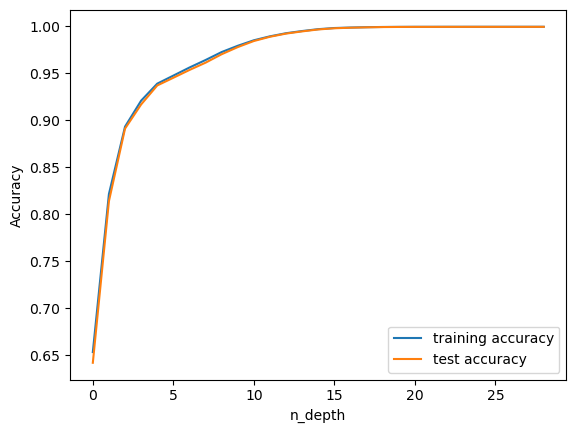

In [19]:
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test_normalized)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.013382451467119272


In [21]:
from sklearn.model_selection import cross_val_score

# Define the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train_normalized, y_train, cv=10, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R2 Scores:", cv_scores)

# Calculate the mean R2 score across all folds
mean_cv_r2 = cv_scores.mean()
print("Mean Cross-Validation R2 Score:", mean_cv_r2)

Cross-Validation R2 Scores: [0.99958461 0.99958885 0.99960566 0.99957543 0.99946342 0.99958257
 0.99951916 0.99930667 0.99945782 0.99942363]
Mean Cross-Validation R2 Score: 0.9995107829505872


In [28]:
from sklearn.preprocessing import OneHotEncoder


def generate_dummy_for_region(user_input):
    regions = ['Region_ashanti',
       'Region_brong ahafo', 'Region_central', 'Region_eastern',
       'Region_greater accra', 'Region_northern', 'Region_upper east',
       'Region_upper west', 'Region_volta', 'Region_western']
    if user_input in regions:
        # Create a dictionary with all months as 0 except the selected month as 1
        dummy_dict = {region: 0 for region in regions}
        dummy_dict[user_input] = 1

        # Convert the dictionary to a DataFrame
        dummy_df = pd.DataFrame(dummy_dict, index=[0])
        return dummy_df

def generate_dummy_for_commodity(user_input):
    commoditys = ['Commodity_cocoyam',
       'Commodity_maize', 'Commodity_millet', 'Commodity_rice',
       'Commodity_sorghum', 'Commodity_yam']
    # Check if user input is a valid month
    if user_input in commoditys:
        # Create a dictionary with all months as 0 except the selected month as 1
        dummy_dict = {commodity: 0 for commodity in commoditys}
        dummy_dict[user_input] = 1

        # Convert the dictionary to a DataFrame
        dummy_df = pd.DataFrame(dummy_dict, index=[0])
        return dummy_df

def preprocess_inputs(year, area, rainfall, commodity, region):
    regions = generate_dummy_for_region(region)
    commoditys = generate_dummy_for_commodity(commodity)
    preprocessed_inputs = np.concatenate([year, area, rainfall,commoditys.values, regions.values], axis=None)
    return preprocessed_inputs


In [29]:
# Save the trained model
joblib.dump(model, 'model.joblib')

# Save the preprocessing and prediction functions using pickle
import pickle
with open('preprocess_inputs.pkl', 'wb') as f:
    pickle.dump(preprocess_inputs, f)

In [25]:
# Example values for testing
year = [2022]
area = [1000]
rainfall = [500]
commodity = 'Commodity_millet'
region = 'Region_northern'

# Test the preprocessing function
preprocessed_inputs = preprocess_inputs(year, area, rainfall, commodity, region)
print("Preprocessed inputs:", preprocessed_inputs)


Preprocessed inputs: [2022 1000  500    0    0    1    0    0    0    0    0    0    0    0
    1    0    0    0    0]
